**Project 7**

**Name:** Megha Ukkali and Sagar Pandya


**Course:** Advanced Machine Learning

**Submission Date:** 05/04/2020


# **Part I: RNN/LSTM/GRU**

In this exercise, you are to work in your previous group on stock market forecast. Collect performance data for a period of 12 months for a favorite stock (Apple, Google, etc.) and perform the following tasks: 

We choose Facebook Stock here:-

1) Use the most accurate model (LSTM or GRU)  that best predicts the collected data pertaining to the past 12 months. Pay special attention to the selected #units, activation functions, dropouts, dense layer configuration, etc.

2) Use your model from part 1 to make predictions for the next month, next 5 months, and the next 10 months. 

3) Make sure to plot your results in both parts 1 and 2.

4) Fully discuss and justify your results. 


# **Setup here:-**

In [234]:
# Python ≥3.5 is required here
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required here
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required here
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports here
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
import sklearn
import sklearn.preprocessing
from sklearn import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.models import load_model
import keras
import h5py
import requests
import math, time

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# **Import The Facebook CSV Dataset(12 Months) Using Pandas :-**

In [235]:
import pandas as pd
url = 'https://raw.githubusercontent.com/pandyasagar323/Advance-Machine-Learning-/master/Project%207/Facebook%202019-2020.csv'
fb_data = pd.read_csv(url)
fb_data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,5/1/2019,194.779999,196.179993,193.009995,193.029999,193.029999,15996600,Facebook
1,5/2/2019,193.000000,194.000000,189.750000,192.529999,192.529999,13209500,Facebook
2,5/3/2019,194.380005,196.160004,193.710007,195.470001,195.470001,14575400,Facebook
3,5/6/2019,191.240005,194.279999,190.550003,193.880005,193.880005,13994900,Facebook
4,5/7/2019,192.539993,192.899994,187.850006,189.770004,189.770004,16253000,Facebook


### **Let’s explore the data a little bit by checking the number of rows and columns in our datasets.**

In [236]:
fb_data.shape

(251, 8)

### **Let's Check here Information of the dataset explaining which datatype.**

In [237]:
fb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
 7   Name       251 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 15.8+ KB


**Data Set Description here** :- We Use here Facebook Dataset and First of all date column  which is shows that date for the stocks, Open column which is  shows that  opening price for stocks that day , The High column which is shows  that  highest price stock  achieved for  that day , The Low column which is  shows  that lowest price stocks achieved for that day , The Close coloumn which is shows that the closing price achieved for stocks that day , The Adj Close column which is  shows that  closing price  of the stock in relation to other stock attributes here , Volume coloumn which is  shows that the volume for the Stock.And also Name column which is just shows that Company name here.

### **To see the statistical details of the dataset, we can use describe()**

In [238]:
fb_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,190.165378,192.382789,187.711992,190.187131,190.187131,1.692261e+07
std,15.491393,14.868625,16.153672,15.516957,15.516957,8.274631e+06
min,139.750000,148.179993,137.100006,146.009995,146.009995,6.046300e+06
25%,181.904999,183.969993,179.955002,181.634995,181.634995,1.141665e+07
50%,189.880005,191.160004,187.279999,189.500000,189.500000,1.459350e+07
75%,200.000000,202.400002,198.120002,199.769996,199.769996,1.969360e+07
max,222.570007,224.199997,221.279999,223.229996,223.229996,5.605960e+07


### **Let's Check if any missing value present or not**

In [239]:
fb_data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64

Here is not present any missing value.

### **Let's Plot the Dataset Using Matplotlib(Data Visualization For the Facebook Dataset)**

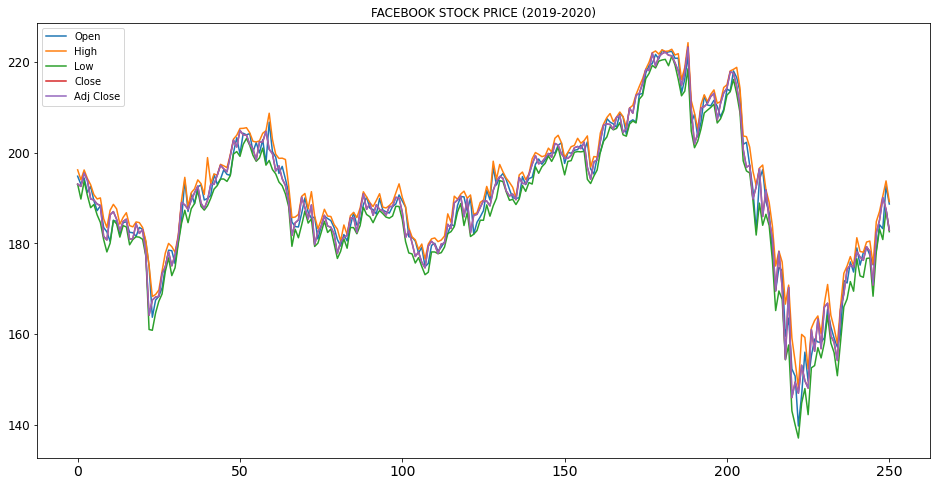

In [288]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 8))
plt.plot(fb_data["Open"])
plt.plot(fb_data["High"])
plt.plot(fb_data["Low"])
plt.plot(fb_data["Close"])
plt.plot(fb_data["Adj Close"])
plt.title('FACEBOOK STOCK PRICE (2019-2020)')
plt.legend(['Open','High','Low','Close','Adj Close'], loc='upper left')
plt.show()

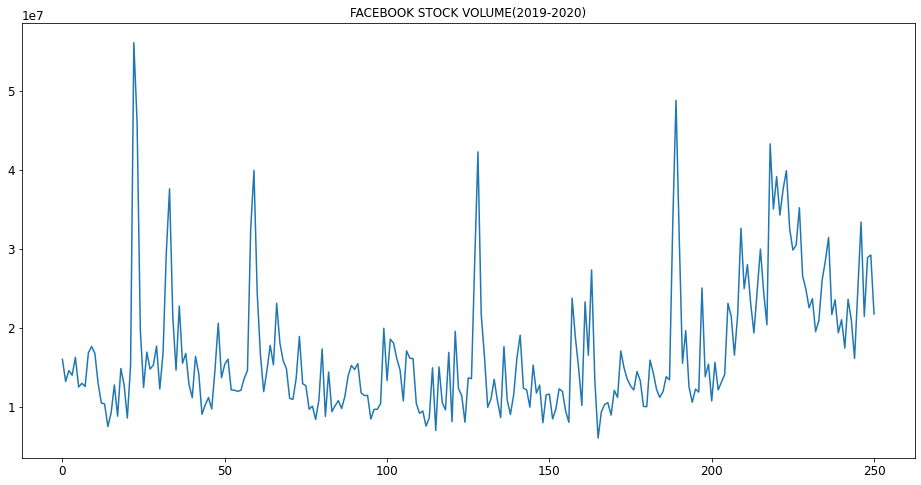

In [241]:
plt.figure(figsize=(16, 8))
plt.plot(fb_data["Volume"])
plt.title('FACEBOOK STOCK VOLUME(2019-2020)')
plt.show()

# **Data Normalization**

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. and also improve the performace of the our model. we used here min-max scaler  from the sci-kit learn. This method rescales the range of the data to [0,1]. In most cases, standardization is used feature-wise as well.

In [0]:
# feture Scaling ,Min-max normalization
def data_normalize(fb_data):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    fb_data['Open'] = min_max_scaler.fit_transform(fb_data.Open.values.reshape(-1,1))
    fb_data['High'] = min_max_scaler.fit_transform(fb_data.High.values.reshape(-1,1))
    fb_data['Low'] = min_max_scaler.fit_transform(fb_data.Low.values.reshape(-1,1))
    fb_data['Close'] = min_max_scaler.fit_transform(fb_data['Close'].values.reshape(-1,1))
    return fb_data

In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) #5 column here 
    data = stock.to_numpy() 
    sequence_length = seq_len + 1 # Here index Starting From 0.
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    result = np.array(result)

    row = round(0.9 * result.shape[0]) # 90% split here
    train = result[:int(row), :] # 90% date, all features  here
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

Dropping the columns here because we need to done prediction on main 4 features so we need to drop here date, adj close and volume. and we need to prediction on a open, high,Low and close. This four is main Column for Our Prediction

In [244]:
# Data Manipulation Dropping the Columns here
FB_stock = fb_data.copy()
FB_stock.drop(['Date'],1,inplace=True)
FB_stock.drop(['Adj Close'],1,inplace=True)
FB_stock.drop(['Volume'],1,inplace=True)
FB_stock.drop(['Name'],1,inplace=True)

cols = list(FB_stock.columns.values)
print('FB_stock.columns.values = ', cols)

FB_stock.columns.values =  ['Open', 'High', 'Low', 'Close']


In [0]:
# Data Normalization For the Stock 
FB_stock_norm = FB_stock.copy()
FB_stock_norm = data_normalize(FB_stock_norm)

# **Training and Testing Dataset here:-**

In [0]:
# Training and Testing Facebook Dataset 
seq_len = 22  
x_train, y_train, x_test, y_test = load_data(FB_stock_norm, seq_len)

In [247]:
x_train.shape, y_train.shape

((205, 22, 4), (205,))

In [248]:
x_test.shape, y_test.shape

((23, 22, 4), (23,))

### **Let's plot the Dataset after Training and Testing here:-**

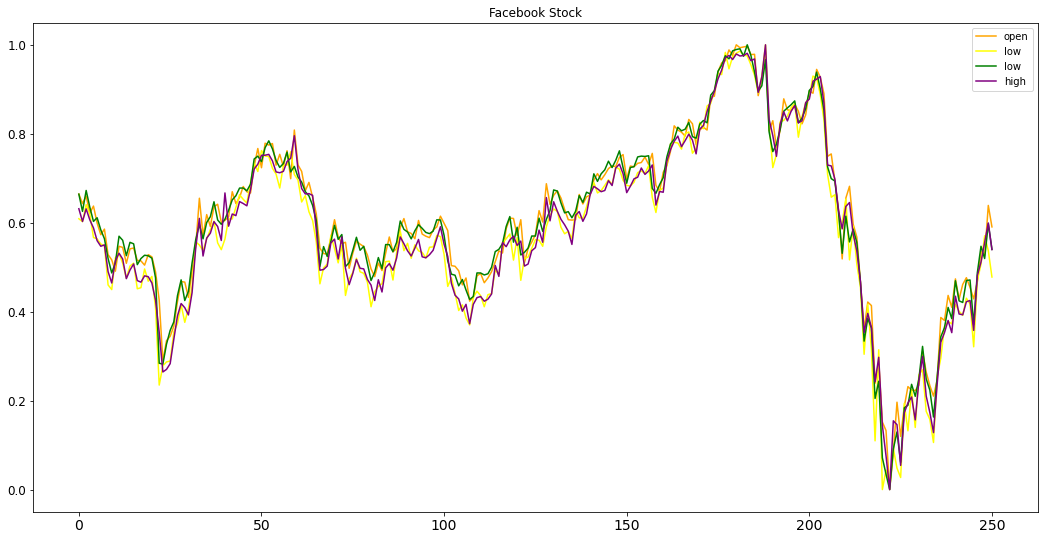

In [290]:
plt.figure(figsize=(18, 9));
plt.plot(FB_stock_norm.Open.values, color='Orange', label='open')
plt.plot(FB_stock_norm.Close.values, color='yellow', label='low')
plt.plot(FB_stock_norm.Low.values, color='Green', label='low')
plt.plot(FB_stock_norm.High.values, color='Purple', label='high')

plt.title('Facebook Stock')
plt.legend(loc='best')
plt.show()

In [0]:
# Import the keras libraries here 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout

### **LSTM MODEL:- Long Short-Term Memory (LSTM) is one of the most widely used recurrent structures in sequence modeling. It uses gates to control information flow in the recurrent computations. LSTM networks are very good at holding long term memories. The memory may or may not be retained by the network depending on the data. Preserving the long term dependencies in the network is done by its Gating mechanisms. The network can store or release memory on the go through the gating mechanism.**

### **USING LSTM MODEL**

In [0]:
def Model_Build(layers):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    #adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [255]:
model = Model_Build([4,seq_len,1])

Compilation Time :  0.023122549057006836


### **Fit the model with Training Set here:-**

In [256]:
LSTM=model.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2,verbose=1)

Train on 164 samples, validate on 41 samples
Epoch 1/20
164/164 [==============================] - 2s 13ms/step - loss: 0.2901 - accuracy: 0.0000e+00 - val_loss: 0.0973 - val_accuracy: 0.0244
Epoch 2/20
164/164 [==============================] - 1s 8ms/step - loss: 0.0392 - accuracy: 0.0000e+00 - val_loss: 0.0971 - val_accuracy: 0.0244
Epoch 3/20
164/164 [==============================] - 1s 7ms/step - loss: 0.0273 - accuracy: 0.0000e+00 - val_loss: 0.0971 - val_accuracy: 0.0244
Epoch 4/20
164/164 [==============================] - 1s 8ms/step - loss: 0.0256 - accuracy: 0.0000e+00 - val_loss: 0.0977 - val_accuracy: 0.0244
Epoch 5/20
164/164 [==============================] - 1s 8ms/step - loss: 0.0281 - accuracy: 0.0000e+00 - val_loss: 0.0984 - val_accuracy: 0.0244
Epoch 6/20
164/164 [==============================] - 1s 8ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0992 - val_accuracy: 0.0244
Epoch 7/20
164/164 [==============================] - 1s 8ms/step - loss: 0.02

### **Let's plot the LSTM Training and Testing.**

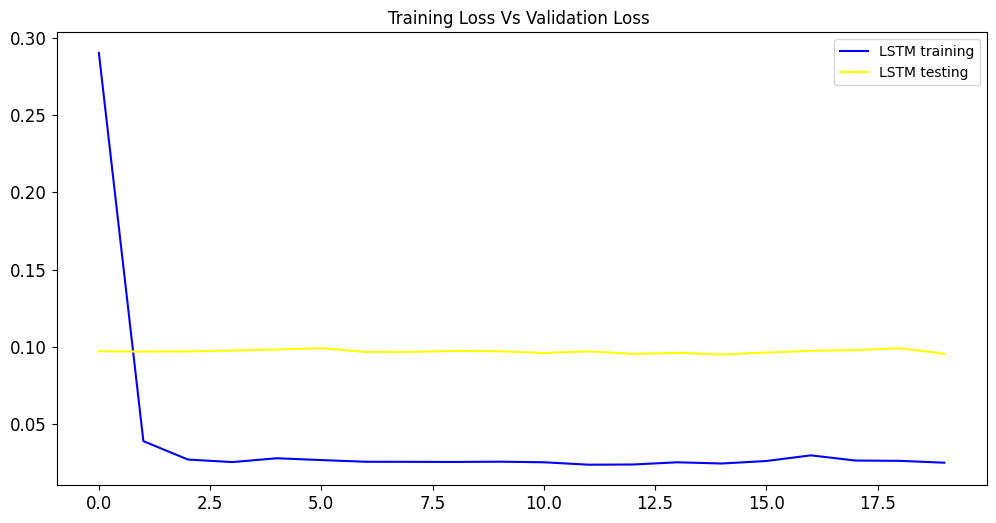

In [257]:
plt.figure(figsize=(12,6),dpi=100)
plt.plot(LSTM.history['loss'],label='LSTM training',color='blue')
plt.plot(LSTM.history['val_loss'],label='LSTM testing',color='yellow')
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.legend()
plt.title('Training Loss Vs Validation Loss ')
plt.show()

### **GRU MODEL :-A gated recurrent unit (GRU) is part of a specific model of recurrent neural network that intends to use connections through a sequence of nodes to perform machine learning tasks associated with memory and clustering, for instance, in speech recognition. Gated recurrent units help to adjust neural network input weights to solve the vanishing gradient problem that is a common issue with recurrent neural networks.**

### **USING GRU MODEL:-**

In [0]:
def Model_Build_GRU(layers):
    d = 0.2
    model_gru = Sequential()
    
    model_gru.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model_gru.add(Dropout(d))
        
    model_gru.add(GRU(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model_gru.add(Dropout(d))
        
    model_gru.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model_gru.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model_gru.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model_gru

In [259]:
Model_GRU = Model_Build_GRU([4,seq_len,1])

Compilation Time :  0.02292013168334961


In [261]:
GRU=Model_GRU.fit(x_train,y_train,batch_size=32,epochs=20,validation_split=0.2,verbose=1)

Train on 164 samples, validate on 41 samples
Epoch 1/20
164/164 [==============================] - 2s 15ms/step - loss: 0.3147 - accuracy: 0.0000e+00 - val_loss: 0.0424 - val_accuracy: 0.0488
Epoch 2/20
164/164 [==============================] - 1s 9ms/step - loss: 0.0460 - accuracy: 0.0000e+00 - val_loss: 0.0513 - val_accuracy: 0.0488
Epoch 3/20
164/164 [==============================] - 2s 9ms/step - loss: 0.0369 - accuracy: 0.0000e+00 - val_loss: 0.0435 - val_accuracy: 0.0488
Epoch 4/20
164/164 [==============================] - 2s 9ms/step - loss: 0.0176 - accuracy: 0.0000e+00 - val_loss: 0.0506 - val_accuracy: 0.0244
Epoch 5/20
164/164 [==============================] - 2s 9ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0402 - val_accuracy: 0.0488
Epoch 6/20
164/164 [==============================] - 1s 9ms/step - loss: 0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0377 - val_accuracy: 0.0488
Epoch 7/20
164/164 [==============================] - 1s 9ms/step - loss: 0.01

### **Let's Plot the GRU Training and Testing.**

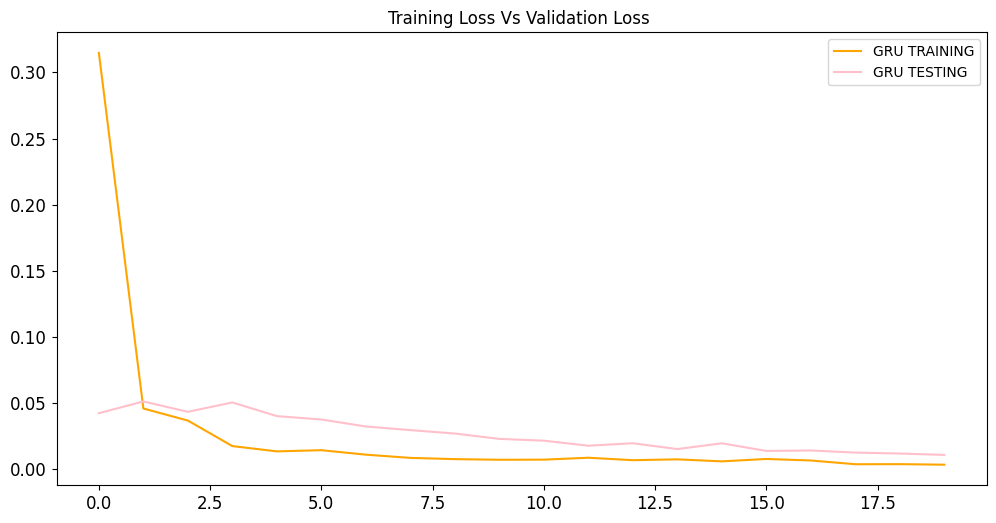

In [262]:
plt.figure(figsize=(12,6),dpi=100)
plt.plot(GRU.history['loss'],label='GRU TRAINING',color='orange')
plt.plot(GRU.history['val_loss'],label='GRU TESTING',color='pink')
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.legend()
plt.title('Training Loss Vs Validation Loss ')
plt.show()

### **Let's plot the Training and Testing GRU and LSTM.**

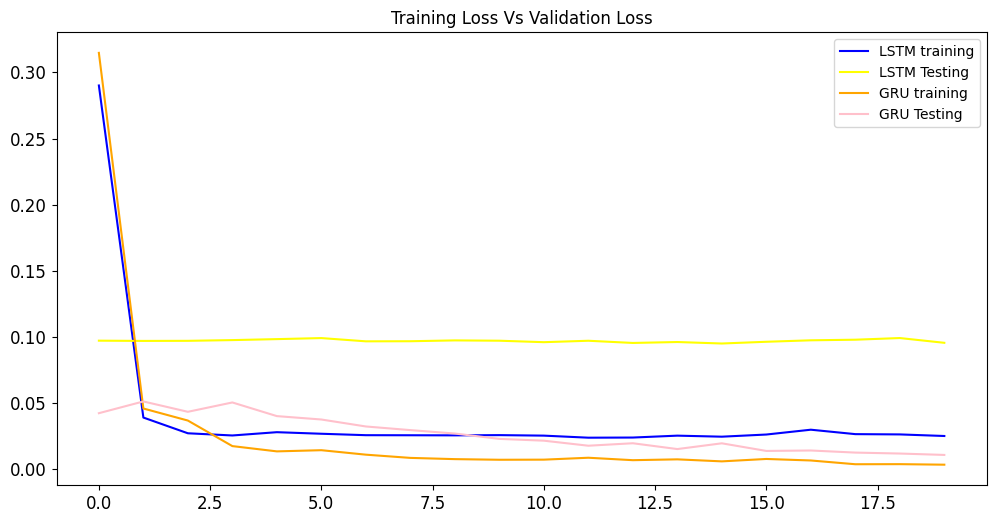

In [263]:
plt.figure(figsize=(12,6),dpi=100)
plt.plot(LSTM.history['loss'],label='LSTM training',color='blue')
plt.plot(LSTM.history['val_loss'],label='LSTM Testing',color='yellow')
plt.plot(GRU.history['loss'],label='GRU training',color='Orange')
plt.plot(GRU.history['val_loss'],label='GRU Testing',color='pink')
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.legend()
plt.title('Training Loss Vs Validation Loss')
plt.show()

The graph shows that GRU which is less Underfitted here.It gives best result for prediction. here we Continued Our model Prediction With the GRU.

In [264]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)
model_score(Model_GRU, x_train, y_train, x_test, y_test)

Train Score: 0.02840 MSE (0.17 RMSE)
Test Score: 0.04160 MSE (0.20 RMSE)
Train Score: 0.00437 MSE (0.07 RMSE)
Test Score: 0.00588 MSE (0.08 RMSE)


(0.004370606445321223, 0.005882274359464645)

Here is the GRU Is the Underfitted Let's take GRU here For Prediction.

In [265]:
diff=[]
ratio=[]
p = Model_GRU.predict(x_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

(23, 1)


In [0]:
#googl = pd.read_csv(url,index_col="Date",parse_dates=True)
def denormalize(fb_data, normalized_value): 
    fb_data = fb_data['Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return goo.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(fb_data)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(fb_data, p)
newy_test = denormalize(fb_data, y_test)
#newy_test = denormalize(goo, y_test)

### **Let's Predicting Facebook Stock For One Month**

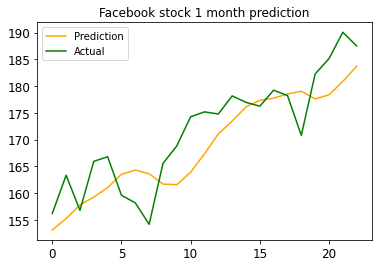

In [272]:
import matplotlib.pyplot as plt2


plt2.plot(newp,color='orange', label='Prediction')
plt2.plot(newy_test,color='green', label='Actual')

#plt2.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]),newp,color='red', label='Prediction')
#plt2.plot(np.arange(y_train.shape[0],y_train.shape[0]+y_test.shape[0]),newy_test,color='blue', label='Actual')
plt2.title('Facebook stock 1 month prediction')
plt2.legend(loc='best')
plt2.show()

### **Let's Predicting Facebook Stock For Five and ten Months here:-**

In [268]:
diff=[]
ratio=[]
M = Model_GRU.predict(x_train)
print (M.shape)
# for each data index in test data
for u in range(len(y_train)):
    # pr = prediction day u
    pr = M[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_train[u]/pr)-1)
    diff.append(abs(y_train[u]- pr))

(205, 1)


In [0]:
ten = denormalize(fb_data, M)
ten_test = denormalize(fb_data, y_train)

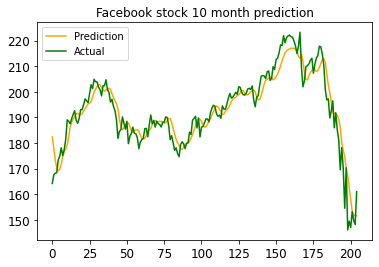

In [271]:
import matplotlib.pyplot as plt2


plt2.plot(ten,color='Orange', label='Prediction')
plt2.plot(ten_test,color='Green', label='Actual')

#plt2.plot(np.arange(y_train_pred.shape[0],y_train_pred.shape[0]+y_test_pred.shape[0]),newp,color='red', label='Prediction')
#plt2.plot(np.arange(y_train.shape[0],y_train.shape[0]+y_test.shape[0]),newy_test,color='blue', label='Actual')
plt2.title('Facebook stock 10 month prediction')
plt2.legend(loc='best')
plt2.show()

### **Conclusion :-**

Here We Consider GRU because it's simple and easy to modify and it's takes less time to train the model. and as well as here GRU is Underfitted and more convenient here in model we shows that prediction for one month which is get better accuraccy actual values goes ups and downs here but the prediction model perform in the graph better result, and also five months and ten months prediction doing also well in model but the Starting to end it goes ups and downs. GRU has two gates and less memory needed and faster operation done it ,LSTM is also Efficient for sequence prediction and time series dataset. 

### **Reference:-**

https://keras.io/getting-started/sequential-model-guide/

https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507

https://github.com/BenjiKCF/Neural-Net-with-Financial-Time-Series-Data/blob/master/Old%20version/LSTM_Stock_prediction_20170508.ipynb

https://www.kaggle.com/dpamgautam/stock-price-prediction-lstm-gru-rnn

https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/

https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

#**PART 2: CNN**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


1.   Train and test the best model you can design to predict picture-specific normative ratings for each of the 10 classes.
2.   Show how you can build a pipeline for preprocessing operations and adding data augmentations, if applicable.
3.   Graph your results from parts 1-2 and discuss what can be done to further improve the classification accuracy of your system.


Import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.And also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#Load Data

Import the neccessary modulee before loading the cifar-10 dataset.


In [0]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()



Normalize pixel values in range  between 0 and 1

In [0]:
train_images, test_images = train_images / 255.0, test_images / 255.0

#Visualizing Training set Images

Plotting the first 20 images from the training set and display the class name below each image.

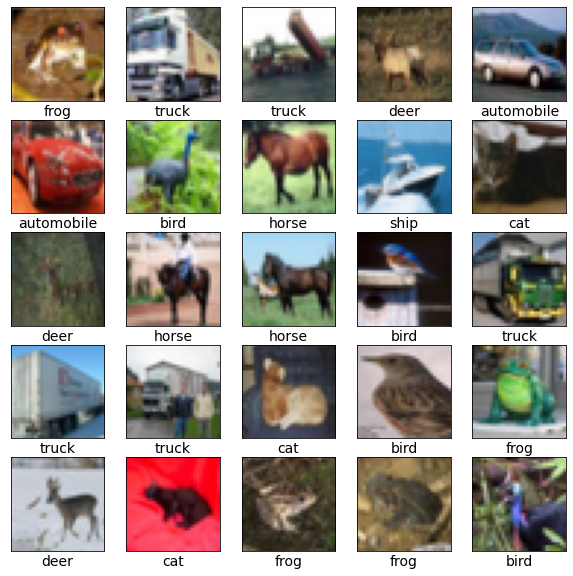

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#Create Model


As input, a CNN takes tensors of shape (image_height, image_width, color_channels), it will be ignoring the batch size. The color_channels refers to (R,G,B).

This layer creates a convolution kernel that is rolled with the layer input to produce a tensor of outputs. If activation is not None, it is applied to the outputs as well.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Configured CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images by passing the argument `input_shape` to first layer.
Configured MaxPooling2D with pool_size: integer of 2 integers, factors by which to downscale (vertical, horizontal). (2, 2) will halve the input in both spatial dimension. 

The architecture of model

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Above output shows that every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions will tend to shrink as go deeper in the network. As the width and height shrink, can afford (computationally) to add more output channels in each Conv2D layer.

Adding Dense layer on top
1. Flatten the 3D output to 1D
2. Adding one or more Dense layers on top. 
Since CIFAR has 10 output classes, used final Dense layer with 10 outputs and a softmax activation.

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

##Model Summary

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

(4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

##Compile the model

The ADAM optimizer and binary cross entropy loss function. 
To view training and validation accuracy for each training epoch, pass the metrics argument.
The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

View all the layers of the network using the model's summary method:

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

##Train the Model

Train the model with setting epochs to 10

In [0]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.5177 - accuracy: 0.4465 - val_loss: 1.2234 - val_accuracy: 0.5616
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1313 - accuracy: 0.5989 - val_loss: 1.1166 - val_accuracy: 0.6008
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9773 - accuracy: 0.6547 - val_loss: 0.9968 - val_accuracy: 0.6529
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8827 - accuracy: 0.6894 - val_loss: 0.9276 - val_accuracy: 0.6772
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8080 - accuracy: 0.7161 - val_loss: 0.8723 - val_accuracy: 0.7033
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7493 - accuracy: 0.7377 - val_loss: 0.9131 - val_accuracy: 0.6882
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7011 - accuracy: 0.7533 - val_loss: 0.9016 - val_accuracy:

##Evaluate the model: Visualizing results

313/313 - 1s - loss: 0.8822 - accuracy: 0.7148


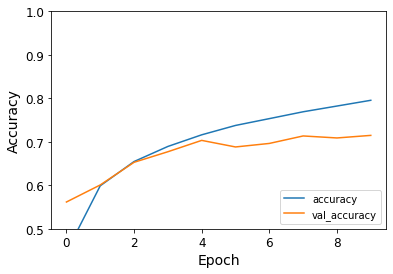

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['validation_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [0]:
print("initial loss: {:.3f}".format(test_loss))
print("initial accuracy: {:.3f}".format(test_acc))

initial loss: 0.882
initial accuracy: 0.715


In [0]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("cifar10", as_supervised=True, with_info=True)

In [0]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=50000>

In [0]:
class_names = info.features["label"].names
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [0]:
n_classes = info.features["label"].num_classes

In [0]:
dataset_size = info.splits["train"].num_examples
dataset_size

50000

In [0]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cifar10",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

#Build a pipeline for preprocessing operations:

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

##Data augmentation


Data augmentation and dropout are the key techniques to fight overfitting in computer vision tasks to incorporate into the data pipeline and image classifier model.

Overfitting generally occurs when there are a small number of training examples. One way to fix this problem is to augment the dataset so that it has a sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples using random transformations that yield believable-looking images. The goal is the model will never see the exact same picture twice during training. This helps expose the model to more aspects of the data and generalize better.

In [0]:
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label



In [0]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [0]:
train_set

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

##Visualize images and its class on Training set.

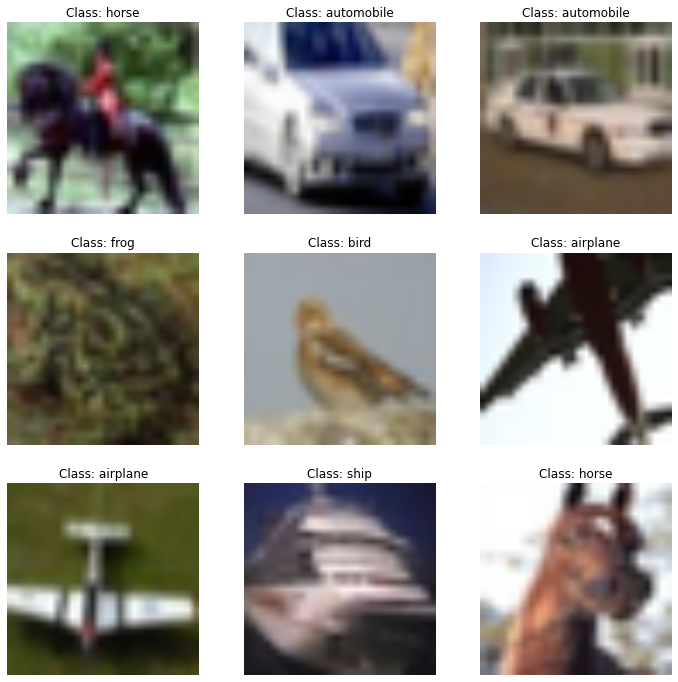

In [0]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

##Visualize images and its class on Test set.

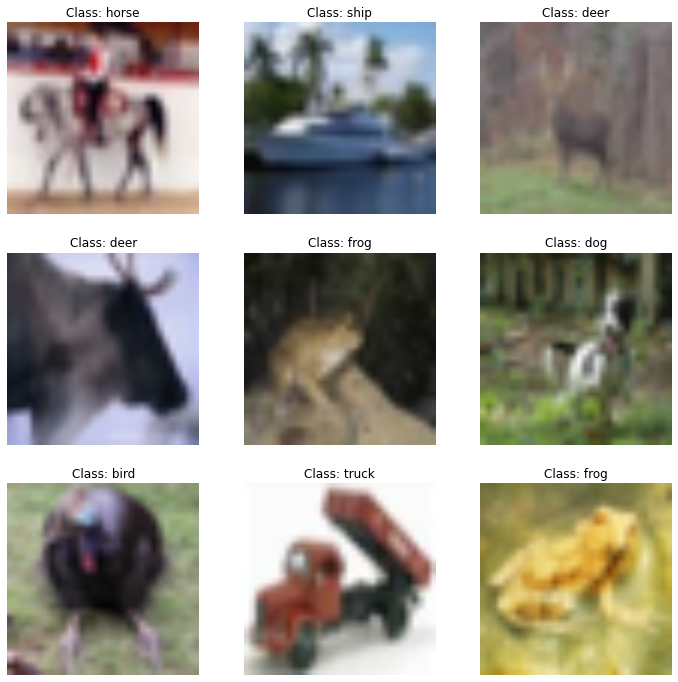

In [0]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [0]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_19
13 block2_pool
14 batch_normalization_8
15 add_24
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_20
23 block3_pool
24 batch_normalization_9
25 add_25
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_21
33 block4_pool
34 batch_normalization_10
35 add_26
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_27
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block

In [0]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
1171/1171 [==============================] - 107s 92ms/step - loss: 0.8712 - accuracy: 0.8213 - val_loss: 0.4692 - val_accuracy: 0.8657
Epoch 2/5
1171/1171 [==============================] - 107s 91ms/step - loss: 0.4261 - accuracy: 0.8661 - val_loss: 0.4192 - val_accuracy: 0.8703
Epoch 3/5
1171/1171 [==============================] - 107s 91ms/step - loss: 0.3828 - accuracy: 0.8754 - val_loss: 0.4062 - val_accuracy: 0.8695
Epoch 4/5
1171/1171 [==============================] - 106s 91ms/step - loss: 0.3557 - accuracy: 0.8803 - val_loss: 0.3887 - val_accuracy: 0.8742
Epoch 5/5
1171/1171 [==============================] - 107s 91ms/step - loss: 0.3394 - accuracy: 0.8847 - val_loss: 0.3805 - val_accuracy: 0.8757


#Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the Xception base model. 

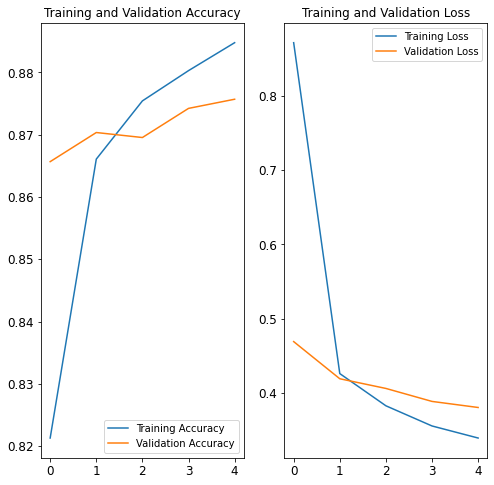

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model has achieved around 88% accuracy on the validation set.
The model shows that there is significantly less overfitting than before. The accuracy go up after preprocessing and adding data augmentation.

In [0]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=15)

Epoch 1/15
1171/1171 [==============================] - 443s 378ms/step - loss: 0.2756 - accuracy: 0.9089 - val_loss: 0.1376 - val_accuracy: 0.9551
Epoch 2/15
1171/1171 [==============================] - 443s 378ms/step - loss: 0.1004 - accuracy: 0.9662 - val_loss: 0.1284 - val_accuracy: 0.9606
Epoch 3/15
1171/1171 [==============================] - 442s 378ms/step - loss: 0.0562 - accuracy: 0.9811 - val_loss: 0.1070 - val_accuracy: 0.9646
Epoch 4/15
1171/1171 [==============================] - 443s 378ms/step - loss: 0.0330 - accuracy: 0.9893 - val_loss: 0.1076 - val_accuracy: 0.9682
Epoch 5/15
1171/1171 [==============================] - 442s 378ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.1057 - val_accuracy: 0.9688
Epoch 6/15
1171/1171 [==============================] - 442s 377ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.1077 - val_accuracy: 0.9683
Epoch 7/15
1171/1171 [==============================] - 442s 377ms/step - loss: 0.0162 - accuracy: 0.9950 - val_

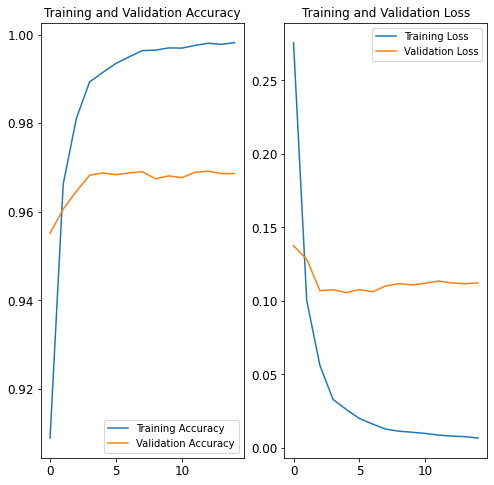

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The new model after training, there is very less overfitting. The accuracy go up after training the model for more epochs.

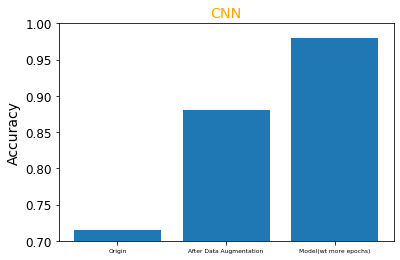

In [0]:
names = ['Origin', 'After Data Augmentation','Model(wt more epochs)']
values = [0.715, 0.88, 0.98]
plt.bar(names, values)
plt.rc('xtick', labelsize=6)
plt.ylim(0.70,1.00)
plt.ylabel("Accuracy")
plt.title("CNN", color = "orange", fontsize = "x-large")
plt.show()

#**SUMMARY**


1.   When Compiled and trained the model before preprocessing, the model has achieved the accuracy of 71.5% and the loss 88.5%.
2.   After applying data augmentation, the model shows accuracy of around 88%.
Data augmentation is the key role in order to avoid Overfitting. While Dropouts are also the key role to reduce overfitting.Dropout is a form of regularization that forces the weights in the network to take only small values.
Experimented with applying Dropouts but it drops to zero duriig training process.

**To improve the performance on the system**, We have to fine tune a pretrained Model.So one should reuse the top level  of pre-trained models to the new dataset via fine-tuning. This technique is usually recommended to the large amount of training dataset.

should try fine-tune a small number of top layers rather than the whole Xception model. The higher up a layer is, the more specialized  convolutional networks. 